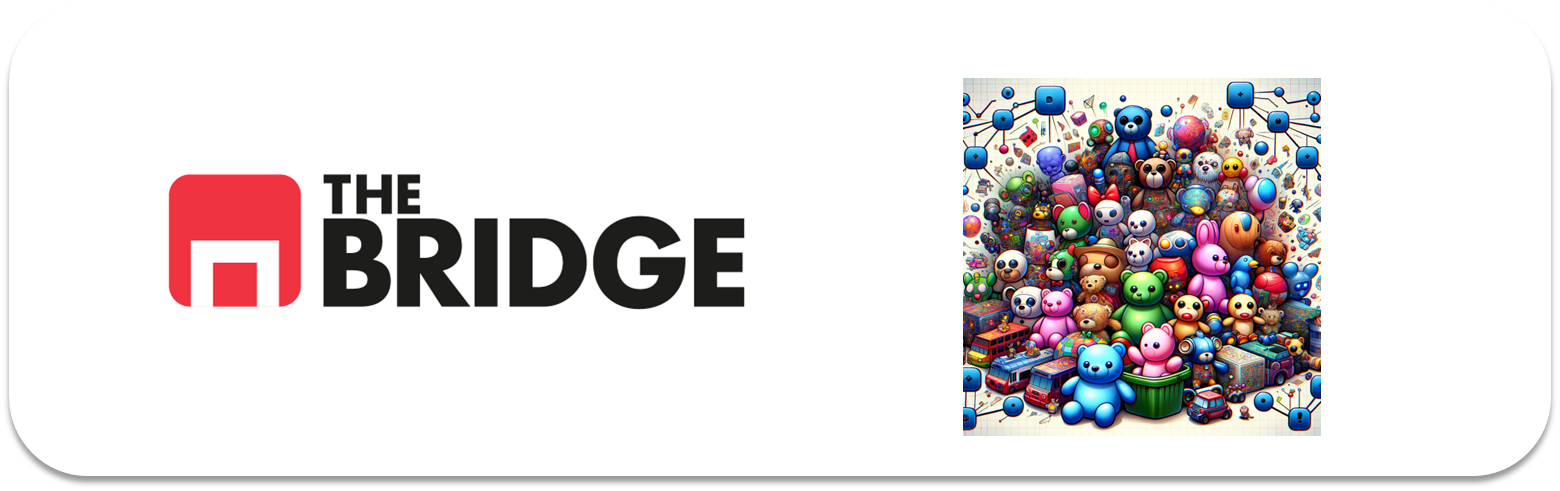

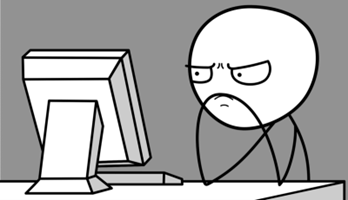

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [93]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import ToolBox as tb
import bootcampviztools as viz
import scipy.cluster.hierarchy as shc

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_olivetti_faces
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


In [94]:
df = pd.read_csv("./data/empowering_drinks.csv", sep = "|")

In [95]:
df.columns = ["azucares", "vitamina_b", "cafeina", "acido_citrico", "taurina"]
df

,azucares,vitamina_b,cafeina,acido_citrico,taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276
...,...,...,...,...,...
148,0.493343,0.414820,-1.284344,0.009893,0.969783
149,0.332758,-0.389355,-1.344582,0.280575,2.224236
150,0.209232,0.012732,-1.354622,0.296498,1.834923
151,1.395086,1.365208,-1.274305,-0.595160,1.791666


In [96]:
df.describe()

,azucares,vitamina_b,cafeina,acido_citrico,taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   azucares       153 non-null    float64
 1   vitamina_b     153 non-null    float64
 2   cafeina        153 non-null    float64
 3   acido_citrico  153 non-null    float64
 4   taurina        153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


*Es un dataset limpio y escalado, como no tenemos target ni categóricas, vamos a pasar directamente a ver un pairplot de todas las variables.*

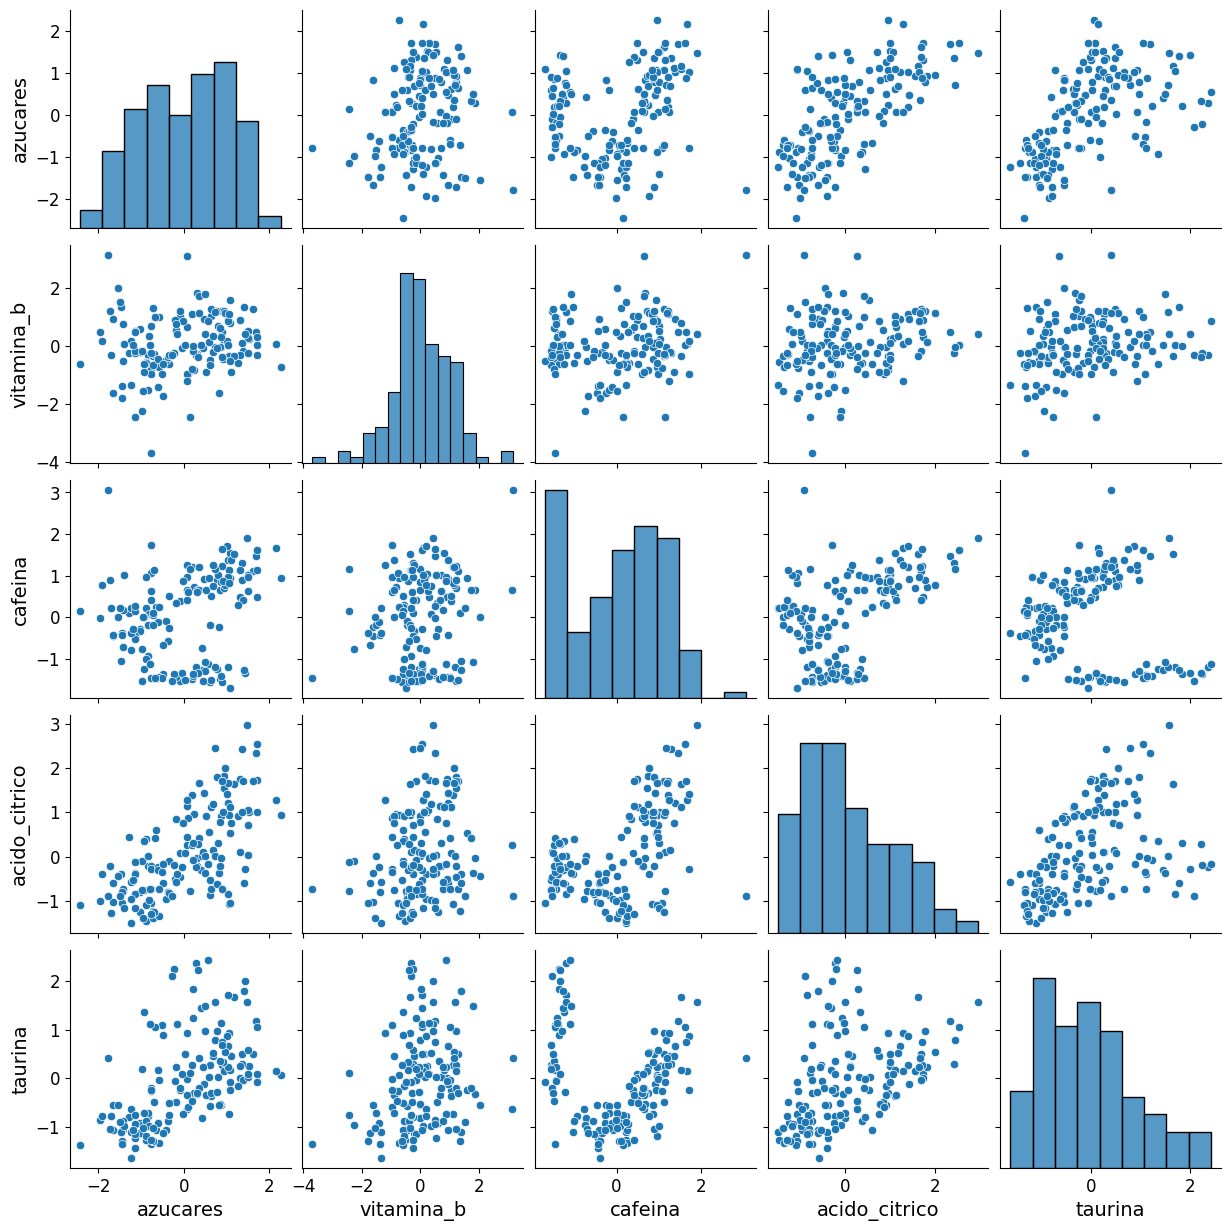

In [98]:
sns.pairplot(df)

*Parece que la feature más diferencial y que más ayudaría a clusterizar es cafeina, parece que se distinguen varios grupos con todas las demás variables, menos con vitamina b. En este último caso no se ve claro, pero podría ser que también hubiese algunos grupos. En principio no la vamos a usar, ya que no parece ser diferencial en combinación con ninguna de las demás features, pero podríamos probar con y sin ella.*

In [99]:
features = df.drop(columns= ["vitamina_b"]).columns.to_list()

*Construyo X_train solo con las features seleccionadas, en caso de querer incluir todas utilizaría "df".*

In [100]:
X_train = df.copy()[features]

### *DBSCAN*

*Voy a empezar con el DBSCAN. Voy a hacer un bucle para que encuentre la primera epsilon que permita hacer una custerización con menos de un 10 % de outliers y un mínimo de valores por cluster que sea el doble de las columnas del dataset, aunque en este caso son muy pocas, pero también tenemos muy pocos datos. Voy a entrenar un modelo con un eps al azar para tantear.*

In [101]:
dbscan = DBSCAN(eps=0.5, min_samples= len(X_train.columns) * 2)
dbscan.fit(X_train)
dbscan.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  1, -1,  0, -1, -1, -1,  0,  1,  1, -1,  1, -1, -1,  0,
       -1, -1, -1, -1, -1, -1, -1,  0,  1, -1,  0,  0, -1,  0, -1,  0, -1,
       -1,  0, -1,  1,  0,  1, -1, -1,  0, -1, -1, -1,  0,  1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [102]:
for n in np.arange(0.5, 1.5, 0.01):
    model = DBSCAN(eps = n, min_samples= len(X_train.columns) * 2)
    pred = model.fit_predict(X_train)
    anomalies = len(pred[pred == -1])/len(pred)
    if anomalies <= 0.1:
        best_model = model
        break
print(best_model)

DBSCAN(eps=np.float64(0.9000000000000004), min_samples=8)


In [103]:
best_model.labels_

array([ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0, -1, -1,  0,  0, -1, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1])

*Solo nos salen 2 clusters y los outliers (que no los podemos considerar como grupo porque no tendrán propiedades en común entre ellos, por eso han quedado fuera), vamos a intentar obtener un cluster más.*

In [104]:
for n in np.arange(0.5, 1.5, 0.001):
    model = DBSCAN(eps = n, min_samples= len(X_train.columns) * 2)
    pred = pd.Series(model.fit_predict(X_train))
    anomalies = len(pred[pred == -1])/len(pred)
    if anomalies <= 0.12 and pred.nunique() >= 4:
        best_model_3 = model
        break
print(best_model_3)

DBSCAN(eps=np.float64(0.8650000000000003), min_samples=8)


In [105]:
best_model_3.labels_

array([ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  1, -1, -1,  1,  0, -1, -1,  1,  1, -1, -1,
        0,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  0,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2, -1, -1,  2,  2,  2,  2, -1,  2])

*Vamos a analizar los clusters a ver si sacamos algo en claro.*

In [106]:
df["labels"] = best_model_3.labels_
df.groupby("labels").median()

,azucares,vitamina_b,cafeina,acido_citrico,taurina
labels,,,,,
-1,0.511872,-0.151758,0.984621,-0.483703,-0.068385
0,0.882451,0.250329,0.889244,0.997086,0.070037
1,-1.137207,-0.316249,-0.109703,-0.824444,-1.020039
2,0.209232,0.025919,-1.414860,-0.268750,0.926526


In [107]:
df.groupby("labels").mean()

,azucares,vitamina_b,cafeina,acido_citrico,taurina
labels,,,,,
-1,0.281975,-0.149728,0.534509,0.013078,0.325254
0,0.784733,0.331922,0.894084,1.010393,0.079152
1,-1.126502,-0.350365,-0.141830,-0.780569,-1.014656
2,0.135714,0.164022,-1.383111,-0.277897,0.841971


*Viendo las medidas de tendencia central de cada uno de los clusters, parece que los del grupo 0 son los que tienen más cafeina, los del grupo 1 están en la parte media y los del grupo 2 son los que menos tienen. También parece que los que menos cafeina tienen tienen más taurina (grupo 2), los del grupo 1 son los que menos taurina tienen y los del grupo 0 están en la parte media. Tanto el ácido cítrico como los azúcares y la vitamina b presentan los valores más altos en las bebidas con más cafeina (grupo 0), valores medios en las bebidas con menos cafeina (grupo 2) y más bajos en las bebidas con nivel de cafeina intermedio (grupo 1). Vemos también que ha hecho un buen trabajo sacando los outliers, ya que tanto media como mediana son bastante similares en la mayoría de los casos.*

*Será interesante ver los histogramas para ver la distribución de valores con más detalle.*

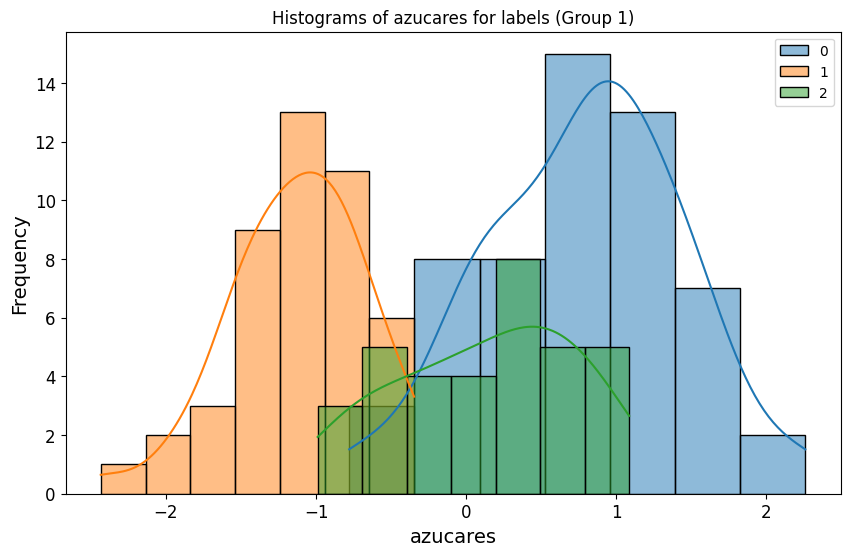

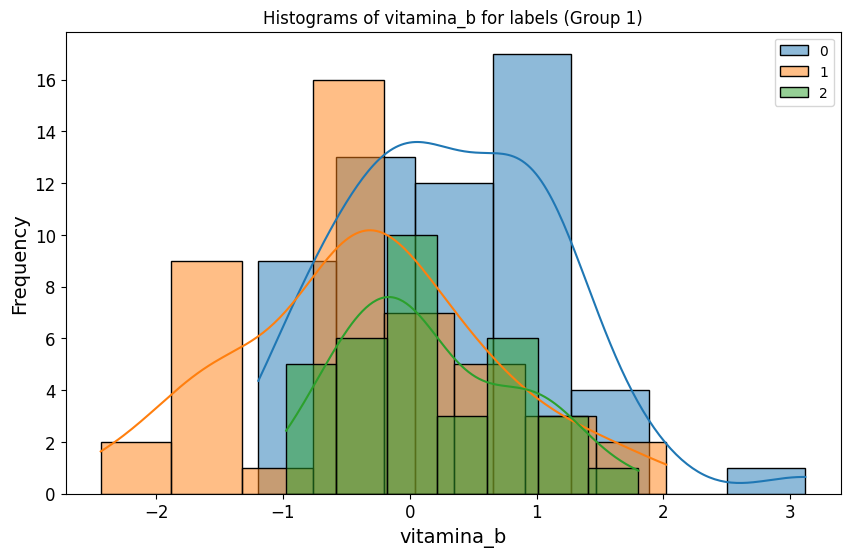

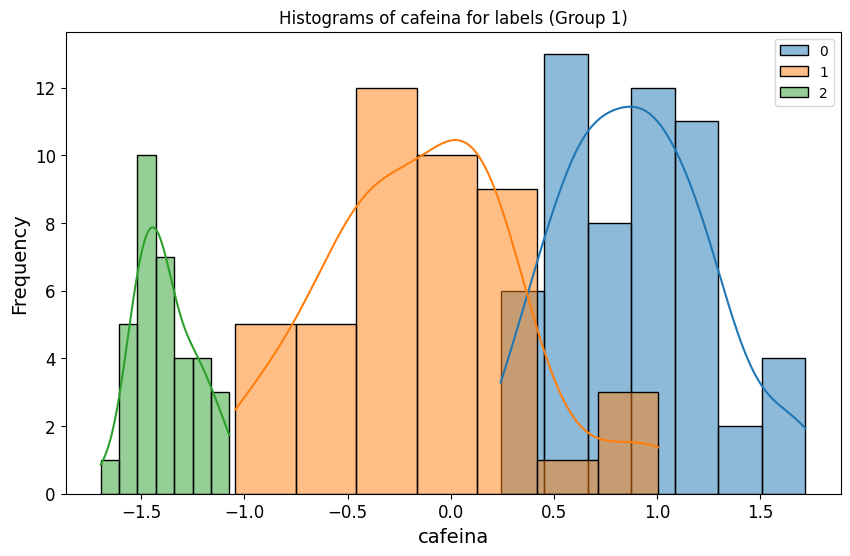

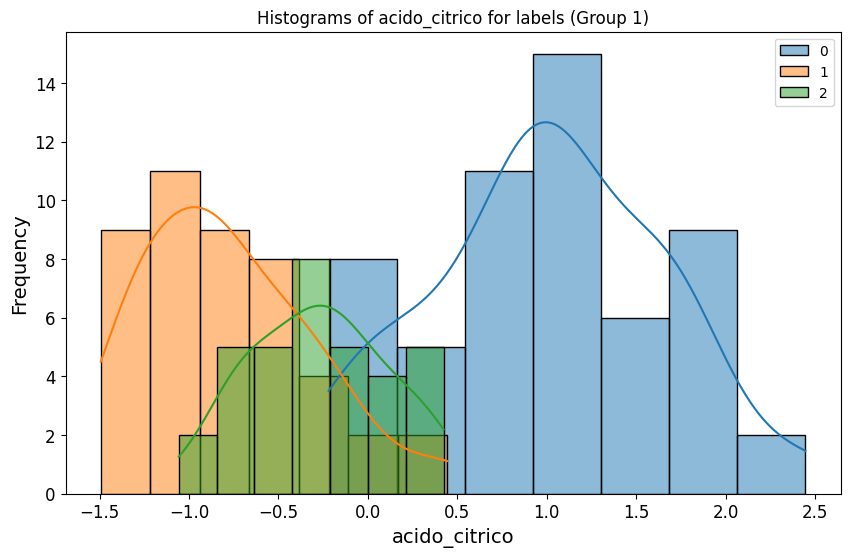

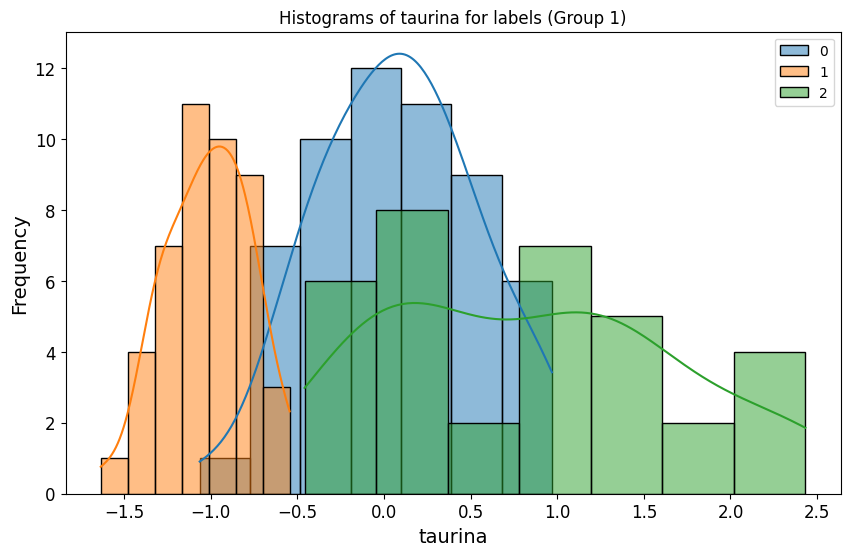

In [108]:
for col in df.loc[df.labels > -1].drop(columns="labels"):
    viz.plot_grouped_histograms(df.loc[df.labels > -1], "labels", col, 3)

*Se puede ver, como habíamos deducido del análisis de las features, que la cafeina es la feature que más ayuda a clusterizar y a grandes rasgos si confirma lo que apreciábamos con las medidas de tendencia central. Los del grupo 2 son los que menos cafeína tienen, pero a cambio, en general tienen más taurina, los del grupo 1 están en los rangos centrales de ambas features y los del grupo 0 son los que más cafeína tienen pero los que menos taurina. En las demás features, los del grupo 0 se encuentran en la parte de arriba, los del 1 en la parte de abajo y los del 2 en la parte central, en un rango más acotado de valores, aunque en estas variables sí que existe más solapamiento, no clusterizan tan claramente como cafeína.*

*Con este algoritmo no podemos detectar cercanían entre clusters, por eso, para tener un poco más claras sus relaciones vamos a usar también un algoritmo de clustering jerárquico aglomerativo.*

<Axes: xlabel='cafeina', ylabel='taurina'>

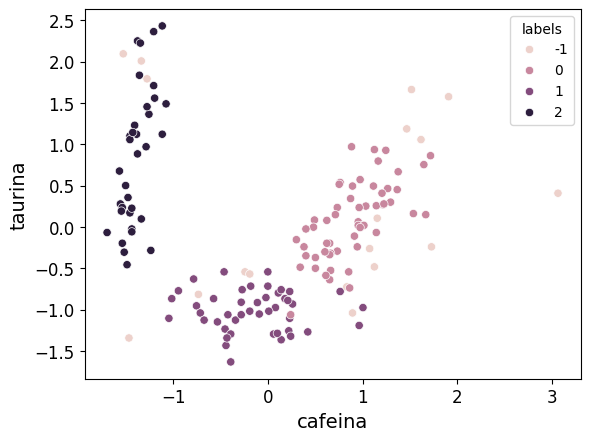

In [109]:
sns.scatterplot(x= "cafeina", y = "taurina", data= df, hue= "labels")

In [110]:
df

,azucares,vitamina_b,cafeina,acido_citrico,taurina,labels
0,1.518613,0.232053,1.034819,1.013009,0.251717,0
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,0
2,0.196879,1.109334,1.215533,1.395148,0.269020,0
3,1.691550,0.487926,1.466525,2.334574,1.186068,-1
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,0
...,...,...,...,...,...,...
148,0.493343,0.414820,-1.284344,0.009893,0.969783,2
149,0.332758,-0.389355,-1.344582,0.280575,2.224236,2
150,0.209232,0.012732,-1.354622,0.296498,1.834923,2
151,1.395086,1.365208,-1.274305,-0.595160,1.791666,-1


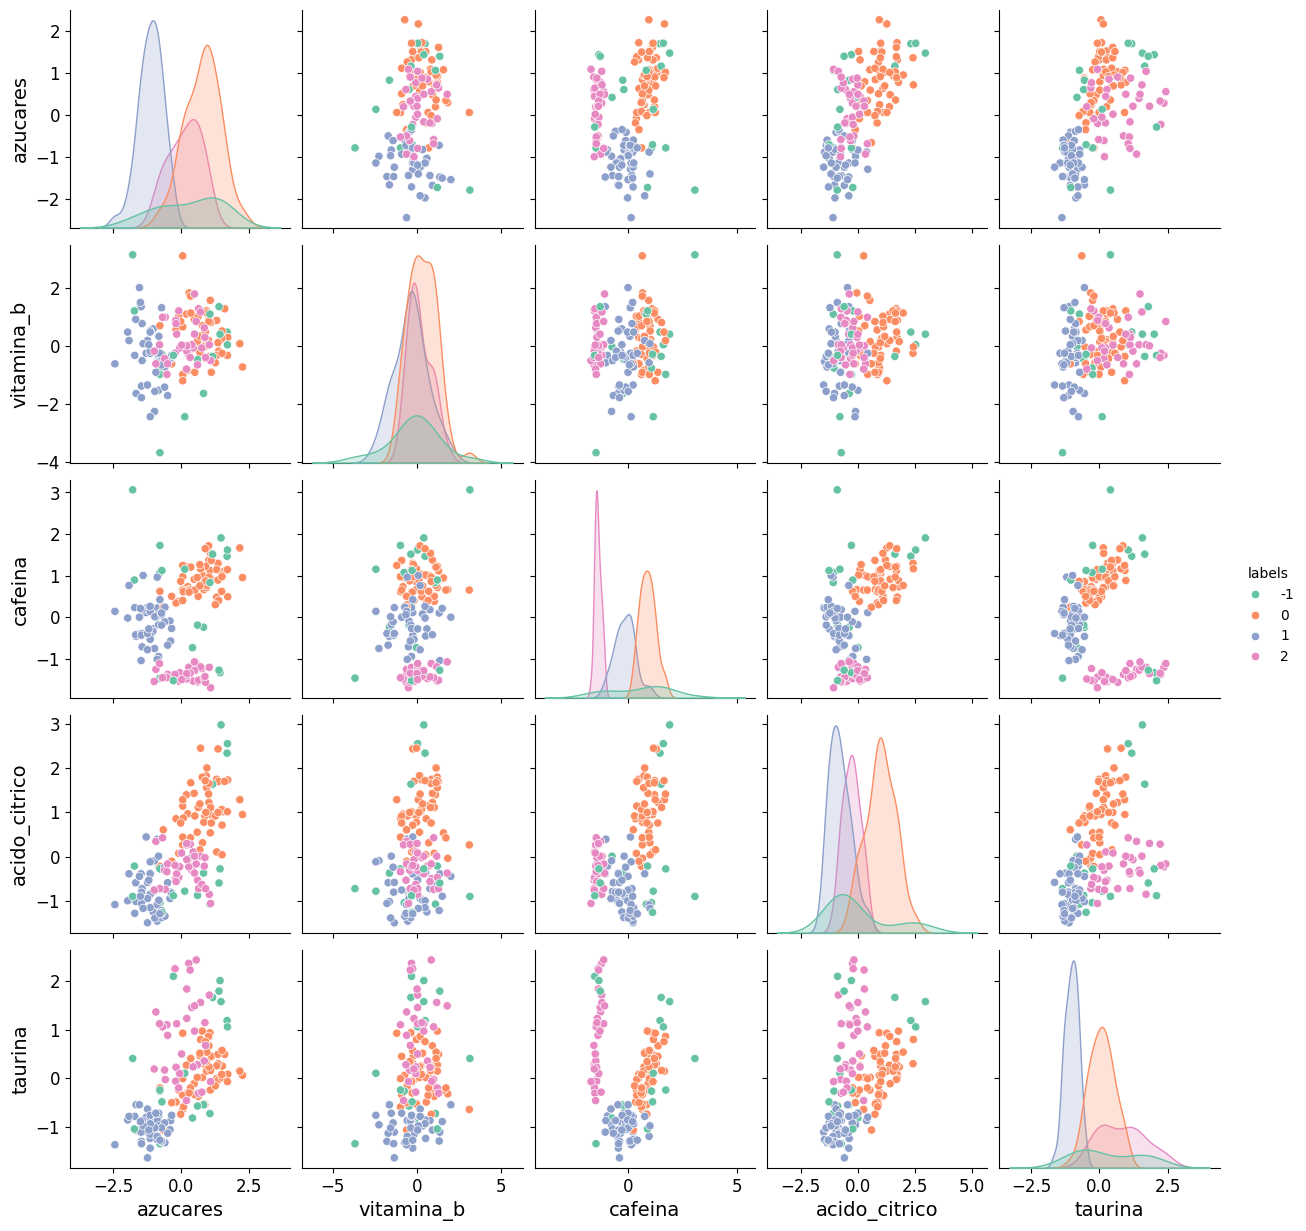

In [111]:
sns.pairplot(data = df, hue= "labels", palette=("Set2"))

### *JERÁRQUICO*

*Vamos a utilizar las mismas features que para el DBSCAN. Vamos a empezar por pintar el dendrograma.*

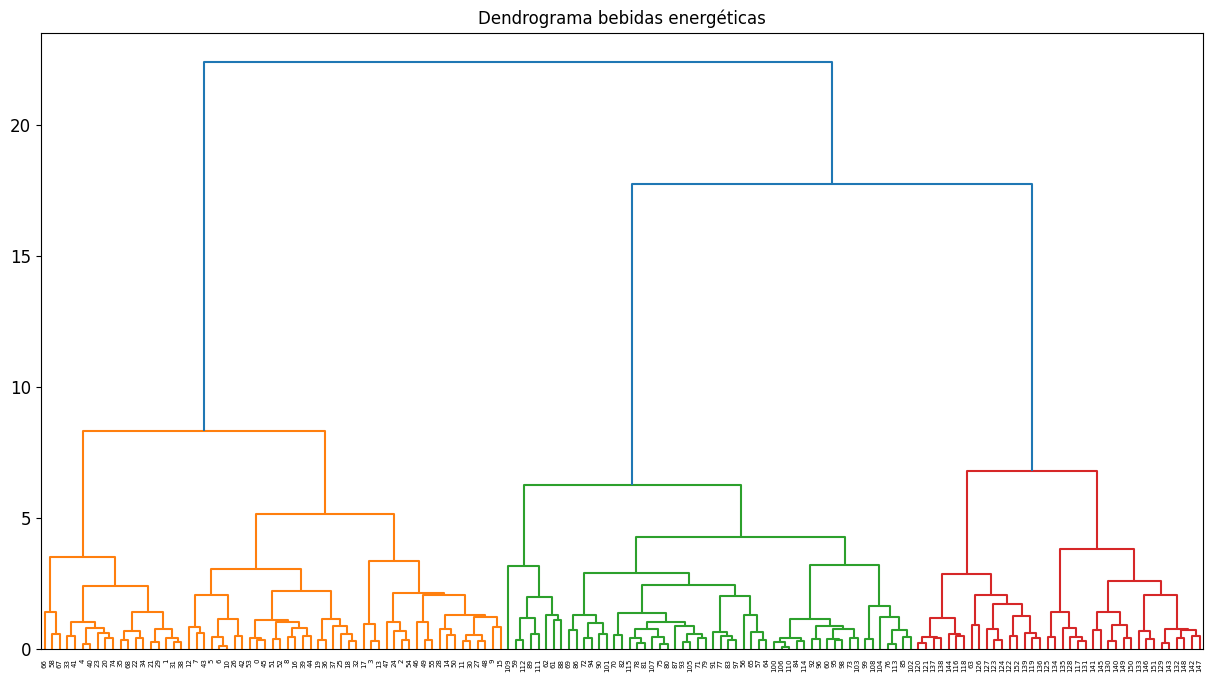

In [152]:
plt.figure(figsize= (15, 8))
plt.title("Dendrograma bebidas energéticas")

clusters = shc.linkage(X_train,
                       method= "ward",
                       metric="euclidean")
shc.dendrogram(Z = clusters)
plt.show();

*Claramente se distinguen 3 clusters. Además, cada uno de ellos se junta más o menos a la misma distancia y están bastante separados entre sí, aunque los dos de la derecha están un poco más cerca entre sí y más lejos del de la izquierda.Podemos pintar la recta de corte por ejemplo en 12.*

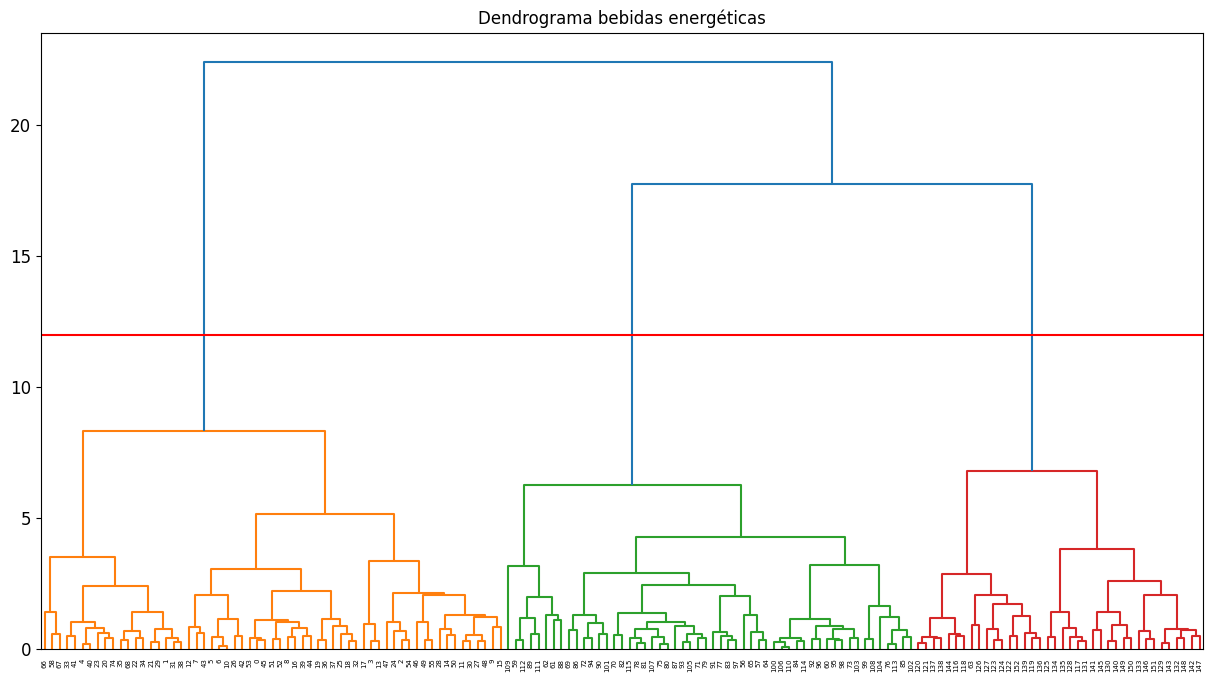

In [113]:
plt.figure(figsize= (15, 8))
plt.title("Dendrograma bebidas energéticas")

clusters = shc.linkage(X_train,
                       method= "ward",
                       metric="euclidean")
shc.dendrogram(Z = clusters)
plt.axhline(y = 12, color = "r")
plt.show();

*Entrenamos el modelo*

In [114]:
cj = AgglomerativeClustering(n_clusters= 3, metric= "euclidean", linkage= "ward", compute_distances= True)
cj.fit(X_train)
cj.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2,
       0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [115]:
df.rename({"labels": "labels_DBSCAN"}, axis=1, inplace=True)

In [116]:
df["labels_JER"] = cj.labels_
df

,azucares,vitamina_b,cafeina,acido_citrico,taurina,labels_DBSCAN,labels_JER
0,1.518613,0.232053,1.034819,1.013009,0.251717,0,0
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,0,0
2,0.196879,1.109334,1.215533,1.395148,0.269020,0,0
3,1.691550,0.487926,1.466525,2.334574,1.186068,-1,0
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,0,0
...,...,...,...,...,...,...,...
148,0.493343,0.414820,-1.284344,0.009893,0.969783,2,1
149,0.332758,-0.389355,-1.344582,0.280575,2.224236,2,1
150,0.209232,0.012732,-1.354622,0.296498,1.834923,2,1
151,1.395086,1.365208,-1.274305,-0.595160,1.791666,-1,1


*Como en el caso anterior, vamos a visualizar las medidas de tendencia central y los histogramas.*

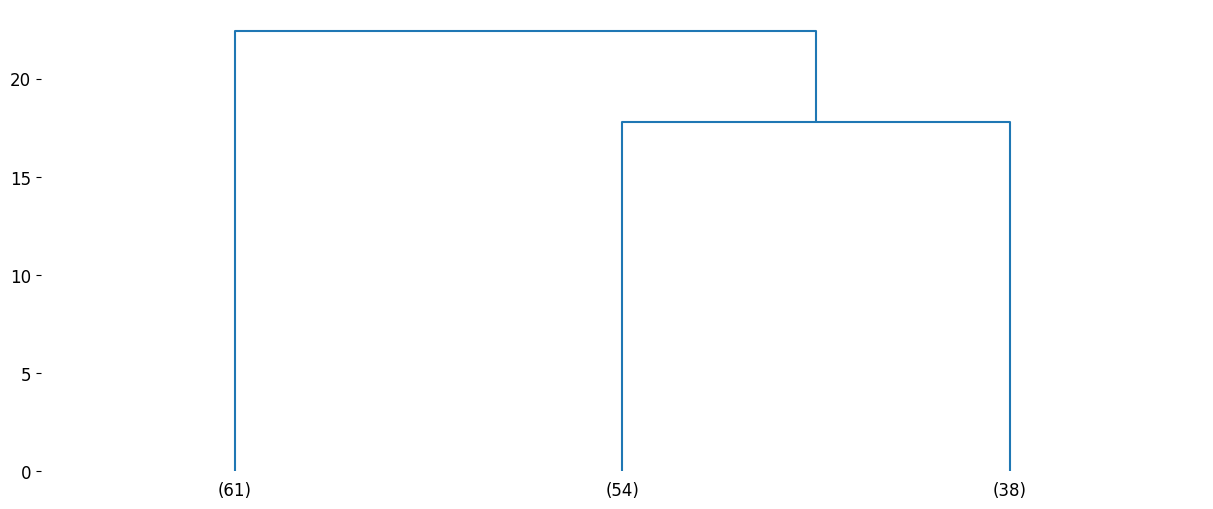

In [117]:
plt.figure(figsize =(15,6))
dend = shc.dendrogram(clusters,
                 truncate_mode='lastp',
                 p = 3, # SUSTITUYE AQUI
                 labels=df.index
                 )
sns.despine(left=True, bottom=True)

In [118]:
df.drop(columns="labels_DBSCAN").groupby("labels_JER").count()

,azucares,vitamina_b,cafeina,acido_citrico,taurina
labels_JER,,,,,
0,61,61,61,61,61
1,38,38,38,38,38
2,54,54,54,54,54


In [158]:
clusters[::-1]

array([[3.02000000e+02, 3.03000000e+02, 2.24201719e+01, 1.53000000e+02],
       [3.00000000e+02, 3.01000000e+02, 1.77804112e+01, 9.20000000e+01],
       [2.96000000e+02, 2.99000000e+02, 8.33043552e+00, 6.10000000e+01],
       [2.90000000e+02, 2.97000000e+02, 6.80821859e+00, 3.80000000e+01],
       [2.93000000e+02, 2.98000000e+02, 6.24696736e+00, 5.40000000e+01],
       [2.92000000e+02, 2.95000000e+02, 5.15291190e+00, 4.20000000e+01],
       [2.91000000e+02, 2.94000000e+02, 4.26774232e+00, 4.60000000e+01],
       [2.76000000e+02, 2.89000000e+02, 3.82936231e+00, 2.10000000e+01],
       [2.74000000e+02, 2.87000000e+02, 3.52617657e+00, 1.90000000e+01],
       [2.51000000e+02, 2.85000000e+02, 3.33938994e+00, 1.90000000e+01],
       [2.60000000e+02, 2.77000000e+02, 3.20227208e+00, 1.90000000e+01],
       [1.09000000e+02, 2.79000000e+02, 3.16145917e+00, 8.00000000e+00],
       [2.84000000e+02, 2.86000000e+02, 3.04259100e+00, 2.30000000e+01],
       [2.68000000e+02, 2.88000000e+02, 2.89916132e

*Los grupos 1 y 2 están más cerca entre sí que del 0, aunque, como hemos dicho, no mucho más cerca y están bastante separados unos de otros.*

In [119]:
df.drop(columns="labels_DBSCAN").groupby("labels_JER").median()

,azucares,vitamina_b,cafeina,acido_citrico,taurina
labels_JER,,,,,
0,0.913333,0.232053,0.914343,1.013009,0.083015
1,0.246290,0.025919,-1.394781,-0.292634,1.013040
2,-1.032210,-0.334525,0.000733,-0.802153,-0.976782


In [120]:
df.drop(columns="labels_DBSCAN").groupby("labels_JER").mean()

,azucares,vitamina_b,cafeina,acido_citrico,taurina
labels_JER,,,,,
0,0.883565,0.296770,0.919939,1.038746,0.153006
1,0.199364,0.184650,-1.365581,-0.294533,0.886957
2,-1.083908,-0.359571,0.038103,-0.739406,-0.921910


*Vemos que los grupos o clusters que ha hecho este modelo de clustering aglomerativo parecen bastante similares a los del DBSCAN por sus valores de tendencia central. Hay un grupo con niveles más altos de cafeina, en este caso el 0, otro con niveles intermedios (grupo 2) y otro con los niveles más bajos (grupo 1). El de los niveles más bajos de cafeína tiene los más altos de taurina (grupo 1) y el grupo 0, que tiene los valores más altos de cafeína tiene valores intermedios de taurina, mientras que el grupo 1 tiene los más bajos. El resto de features toman valores más altos en el grop 0, intermedios en el 1 y más bajos en el 2. Sin embargo, este algoritmo no detecta los outliers, a diferencia del DBSCAN, cosa que podría ser interesante para negocio, así que podríamos informarles de las relaciones que nos permite ver este modelo aglomerativo y además transmitirles que existen outliers.*

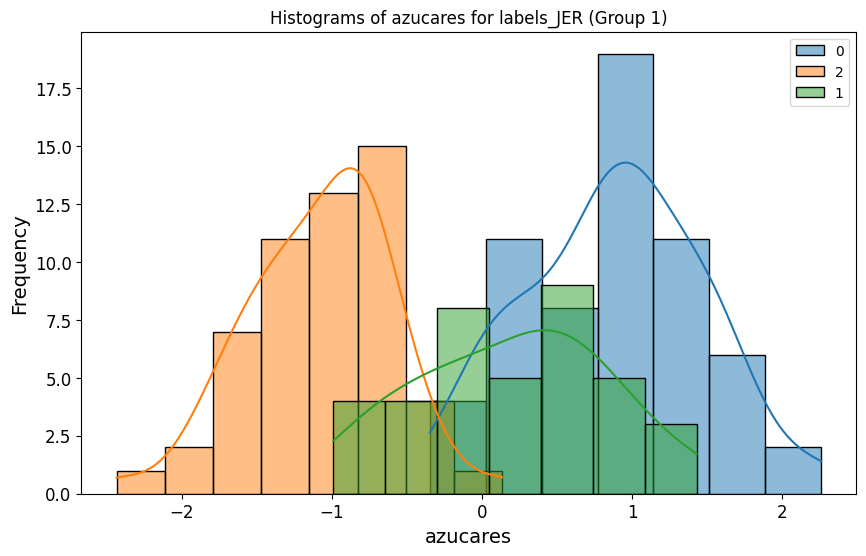

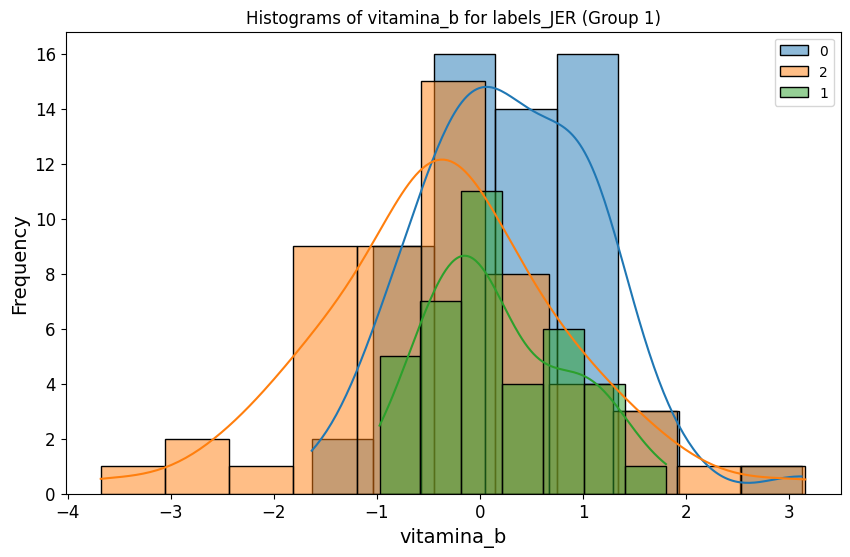

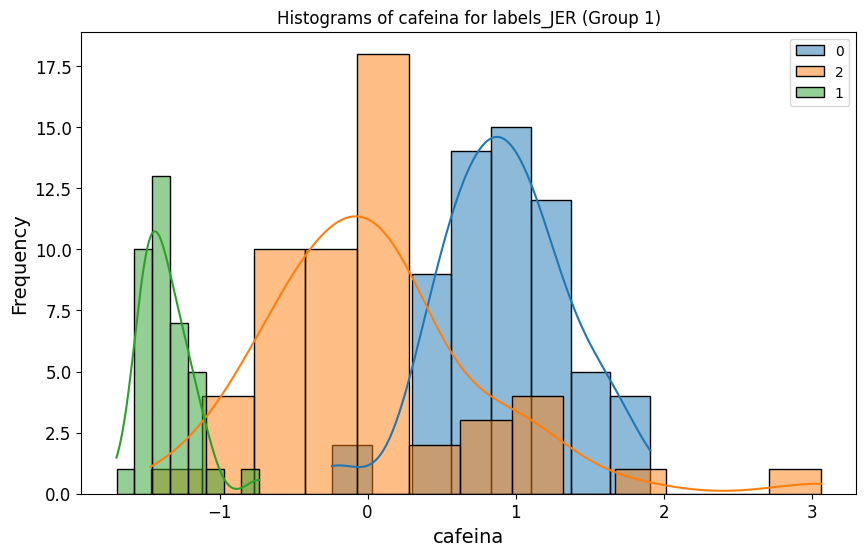

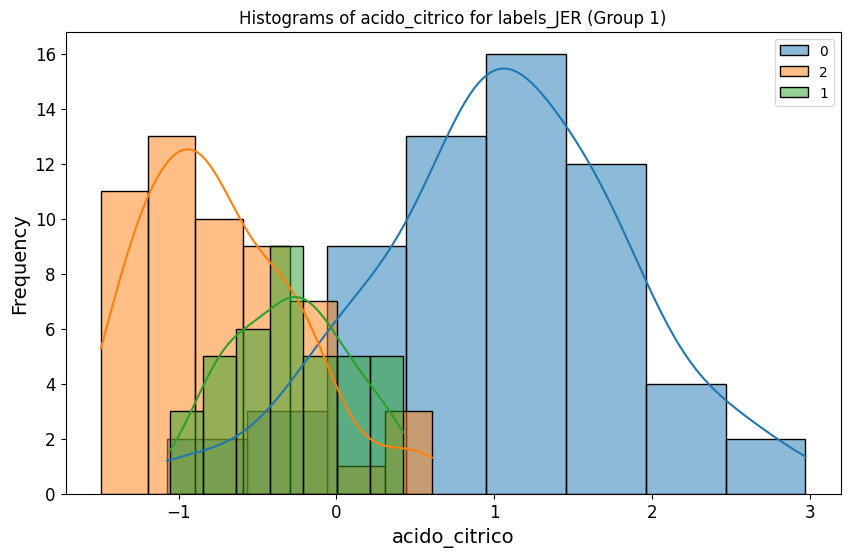

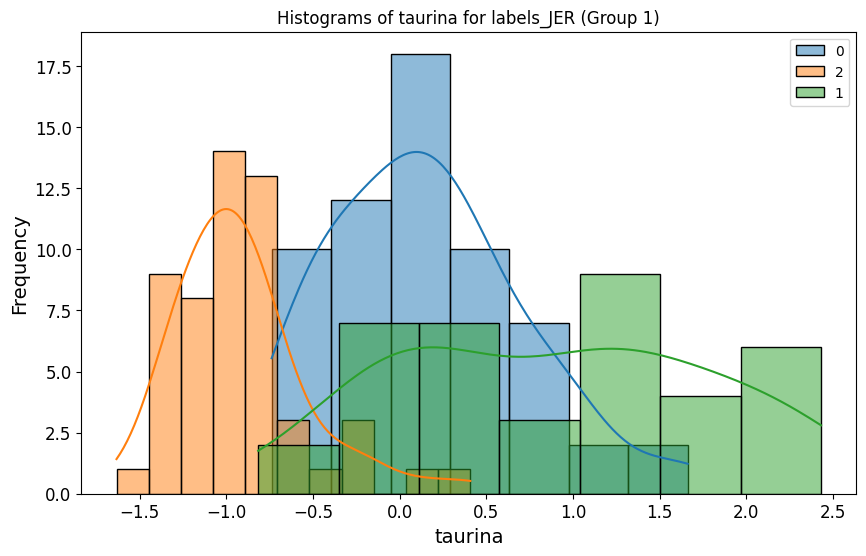

In [121]:
for col in df.loc[df.labels_JER > -1].drop(columns=["labels_DBSCAN", "labels_JER"]):
    viz.plot_grouped_histograms(df.loc[df.labels_JER > -1].drop(columns=["labels_DBSCAN"]), "labels_JER", col, 3)

*Observamos gráficos similares a los resultantes del DBSCAN, pero con algunos valores un poco anómalos debido a que no detecta los outliers, preguntaremos a negocio qué prefiere, si incluir los outliers en los clusters que ha formado el aglomerativo o dejarlos al margen con DBSCAN. Aquí se ve muy claro que la vitamina b es la que menos aporta para clusterizar.*

*Voy a representar los clusters según cafeína y taurina, ya que parece que son las dos features que más ayudan a clusterizar.*

<Axes: xlabel='cafeina', ylabel='taurina'>

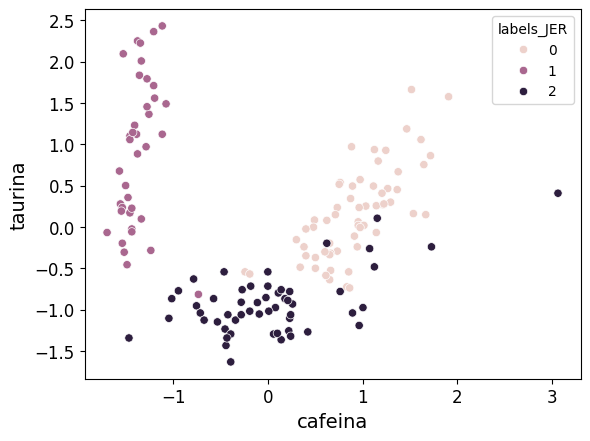

In [122]:
sns.scatterplot(x= "cafeina", y = "taurina", data= df, hue= "labels_JER")

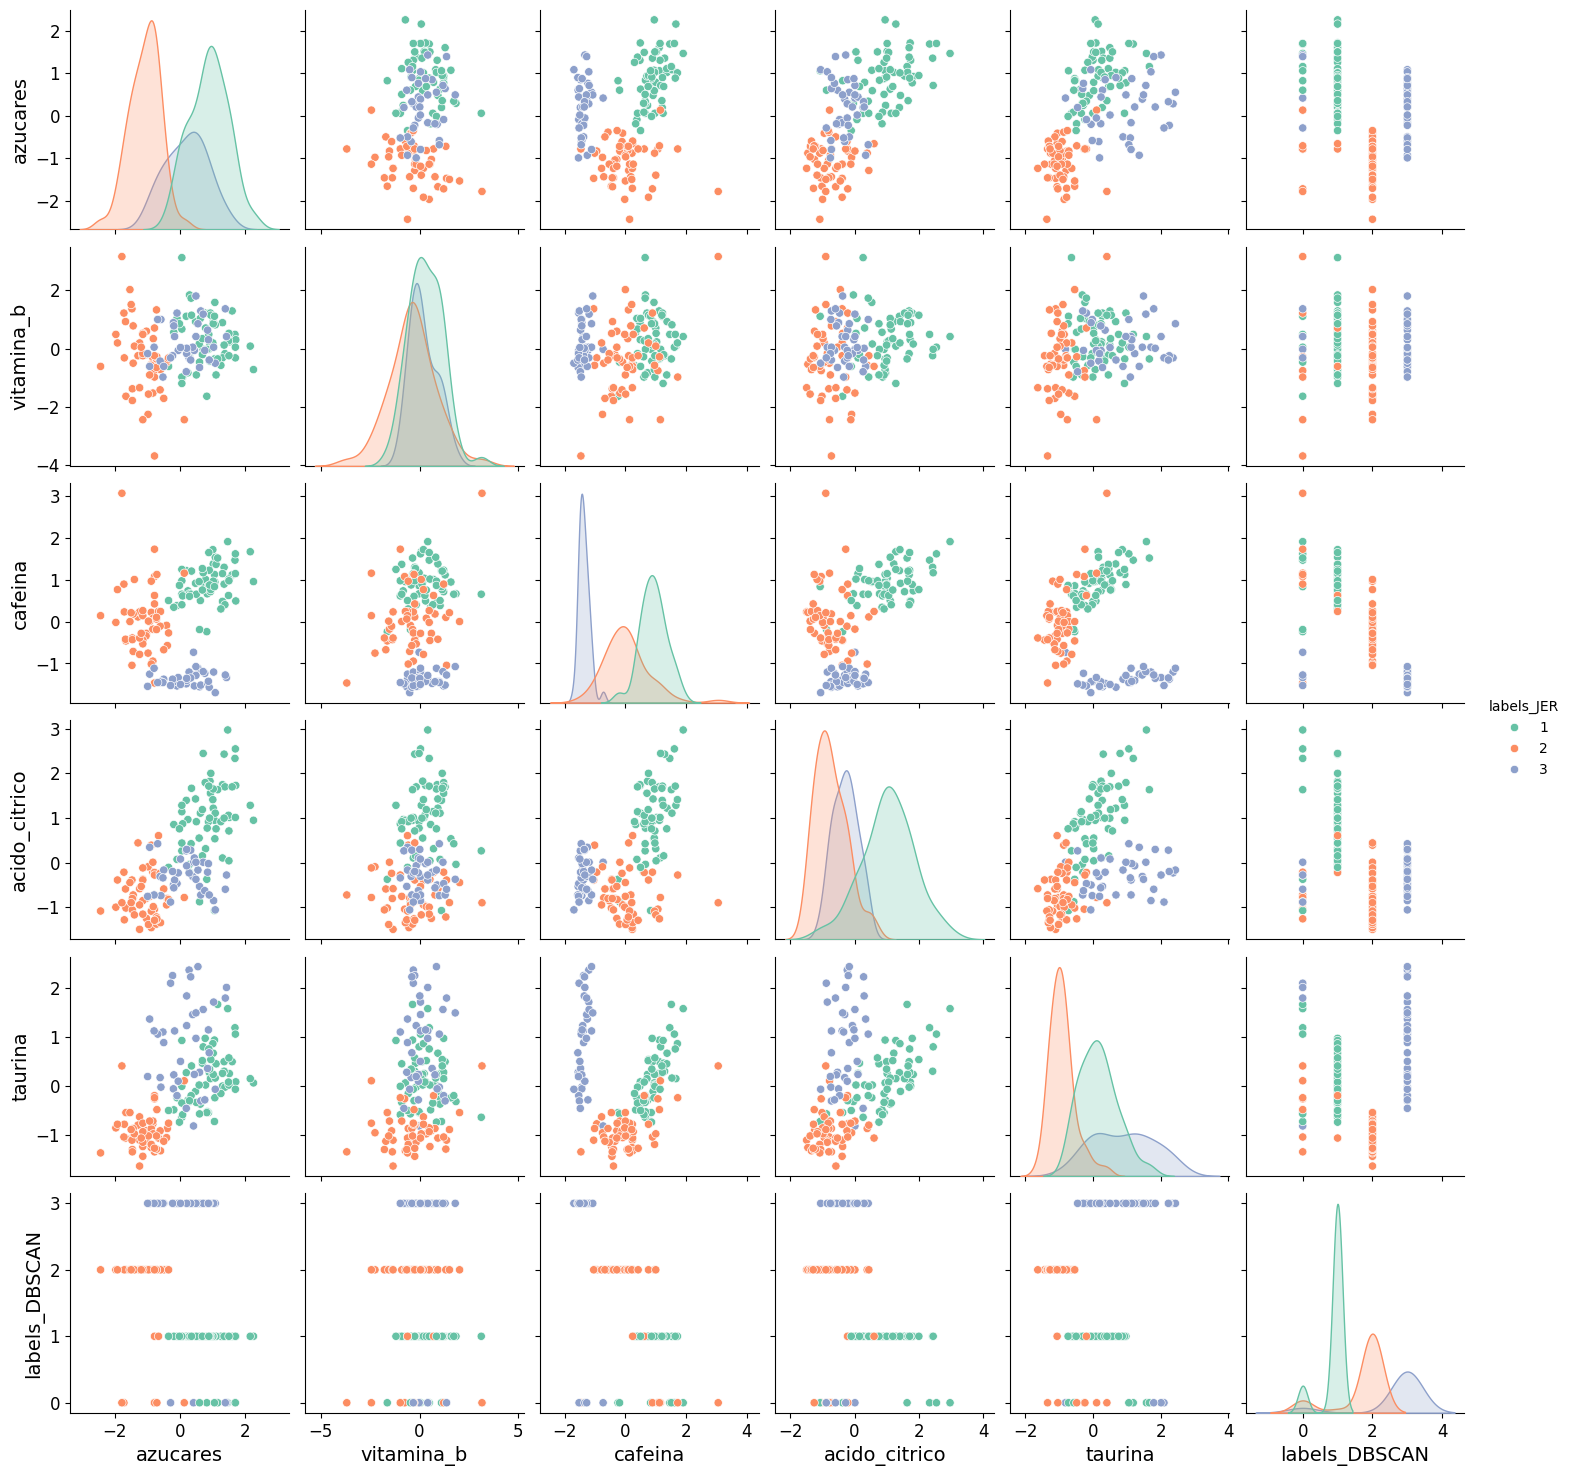

In [150]:
sns.pairplot(data = df, hue= "labels_JER", palette=("Set2"))

*Vemos que coincide bastante con los clusters que se ven aquí a simple vista, pero que también hay otras features que son determinantes.*

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

*Voy a construir 2 KNN que tengan como target las etiquetas asignadas por cada uno de los modelos de clustering.*

In [123]:
X_new = pd.read_csv("./data/new_experiments.csv", sep = "|")
X_new.columns = ["azucares", "vitamina_b", "cafeina", "acido_citrico", "taurina"]
X_new

,azucares,vitamina_b,cafeina,acido_citrico,taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043


In [124]:
y_train_1 = df.labels_DBSCAN
y_train_2 = df.labels_JER

In [125]:
y_train_1

0      0
1      0
2      0
3     -1
4      0
      ..
148    2
149    2
150    2
151   -1
152    2
Name: labels_DBSCAN, Length: 153, dtype: int64

In [126]:
param_grid = {"n_neighbors": np.arange(3,10), "weights": ["uniform", "distance"]}
knn_1 = KNeighborsClassifier()
clf_1 = GridSearchCV(knn_1,
                     param_grid= param_grid,
                     scoring= "accuracy",
                     cv= 4)
clf_1.fit(X_train, y_train_1)

knn_2 = KNeighborsClassifier()
clf_2 = GridSearchCV(knn_2,
                     param_grid= param_grid,
                     scoring= "accuracy",
                     cv= 4)
clf_2.fit(X_train, y_train_2)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([3, 4, 5, 6, 7, 8, 9]),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [127]:
clf_2.best_score_

np.float64(0.9806005398110662)

In [128]:
clf_2.best_params_

{'n_neighbors': np.int64(5), 'weights': 'uniform'}

In [129]:
clf_1.best_score_

np.float64(0.9087381916329285)

In [130]:
clf_1.best_params_

{'n_neighbors': np.int64(3), 'weights': 'uniform'}

In [131]:
pred_1 = clf_1.best_estimator_.predict(X_new[features])

In [132]:
pred_2 = clf_2.best_estimator_.predict(X_new[features])

In [133]:
X_new["labels_DBSCAN"] = pred_1
X_new["labels_JER"] = pred_2
X_new

,azucares,vitamina_b,cafeina,acido_citrico,taurina,labels_DBSCAN,labels_JER
0,1.481555,0.305159,1.366128,2.239039,0.731870,-1,0
1,0.616869,0.890014,0.583034,0.312420,-0.665332,0,0
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782,1,2
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240,1,2
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583,1,2
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043,-1,1


*El clasificador entrenado con los clusters de DBSCAN no ha predicho ningún valor con la etiqueta 2 y sí con -1, tendríamos que saber si negocio quiere identificar esos outliers o le interesa más clasificar todas las instancias en grupos concretos.*

In [134]:
df.drop(columns="labels_DBSCAN").groupby("labels_JER").mean()

,azucares,vitamina_b,cafeina,acido_citrico,taurina
labels_JER,,,,,
0,0.883565,0.296770,0.919939,1.038746,0.153006
1,0.199364,0.184650,-1.365581,-0.294533,0.886957
2,-1.083908,-0.359571,0.038103,-0.739406,-0.921910


In [135]:
df.drop(columns="labels_JER").groupby("labels_DBSCAN").mean()

,azucares,vitamina_b,cafeina,acido_citrico,taurina
labels_DBSCAN,,,,,
-1,0.281975,-0.149728,0.534509,0.013078,0.325254
0,0.784733,0.331922,0.894084,1.010393,0.079152
1,-1.126502,-0.350365,-0.141830,-0.780569,-1.014656
2,0.135714,0.164022,-1.383111,-0.277897,0.841971


### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.

In [136]:
soluciones = pd.read_csv("./data/power_results.csv", sep = "|")
soluciones.iloc[100:]

,class
100,2
101,2
102,2
103,2
104,2
105,2
106,2
107,2
108,2
109,2


In [137]:
df.iloc[100:]

,azucares,vitamina_b,cafeina,acido_citrico,taurina,labels_DBSCAN,labels_JER
100,-0.593691,-0.718336,0.241685,-1.343516,-1.322838,1,2
101,-1.532492,2.023170,0.000733,-0.445489,-0.544212,1,2
102,-1.964835,0.487926,-0.019346,-0.996407,-0.855662,1,2
103,-1.137207,0.487926,0.261765,-1.152447,-0.933525,1,2
104,-2.434235,-0.608676,0.141289,-1.082388,-1.366095,1,2
105,-1.458376,-1.376297,-0.430972,-0.802153,-1.344466,1,2
106,-0.717217,-0.645229,0.060971,-1.279827,-1.296884,1,2
107,-1.236028,-1.339744,-0.390814,-0.582422,-1.634288,1,2
108,-1.915424,0.195499,0.763748,-0.388168,-0.782125,1,2
109,-1.779545,3.156325,3.062832,-0.897687,0.407442,-1,2


*Viendo los valores ya etiquetados por negocio, voy a asignarles los valores equivalentes a mis etiquetas para que representen los mismos grupos y ver cómo ha ido.*

In [138]:
mapping_jer = {0: 1, 2: 2, 1: 3}
df.labels_JER = df["labels_JER"].map(mapping_jer)
df.labels_DBSCAN += 1

*El etiquetado del DBSCAN estaba en el orden correcto, pero eran una unidad menores (ahora los outliers son 0)*

In [139]:
X_new.labels_JER = X_new["labels_JER"].map(mapping_jer)
X_new.labels_DBSCAN += 1
X_new

,azucares,vitamina_b,cafeina,acido_citrico,taurina,labels_DBSCAN,labels_JER
0,1.481555,0.305159,1.366128,2.239039,0.731870,0,1
1,0.616869,0.890014,0.583034,0.312420,-0.665332,1,1
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782,2,2
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240,2,2
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583,2,2
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043,0,3


In [140]:
df_full = pd.concat([df, X_new], ignore_index=True)

In [141]:
df_full["actual_labels"] = soluciones["class"]

In [142]:
df_counts = pd.DataFrame({col: df_full[col].value_counts() for col in ["labels_DBSCAN", "labels_JER", "actual_labels"]})

<Figure size 1500x800 with 0 Axes>

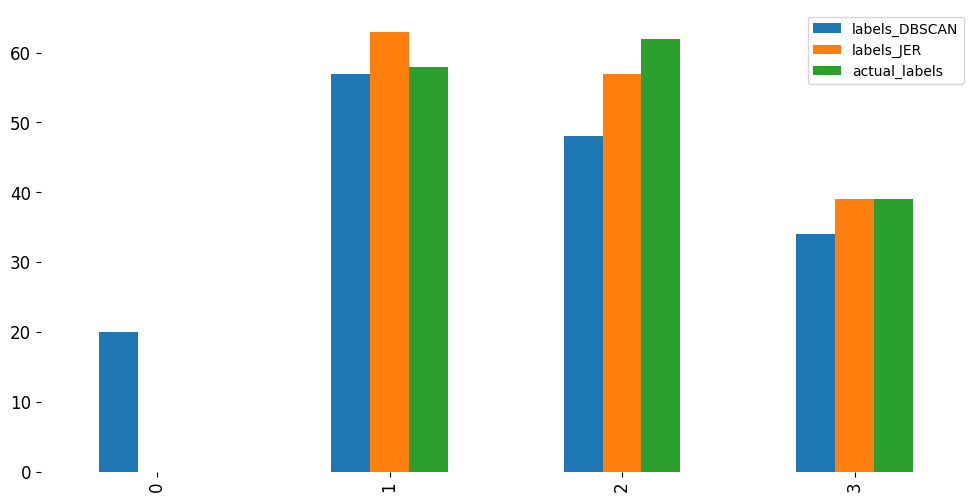

In [149]:
plt.figure(figsize= (15, 8))
df_counts.plot(kind= "bar", figsize=(12, 6))
sns.despine(left=True, bottom=True)

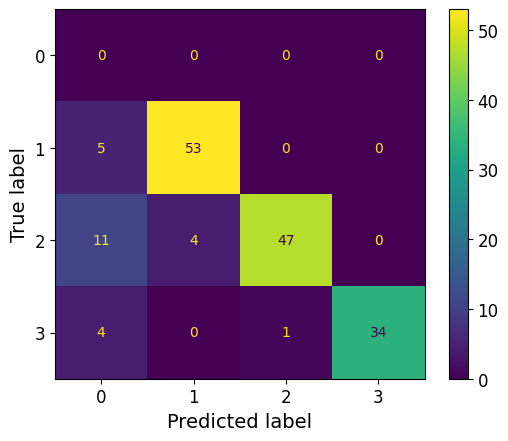

In [144]:
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(df_full.actual_labels, df_full.labels_DBSCAN)

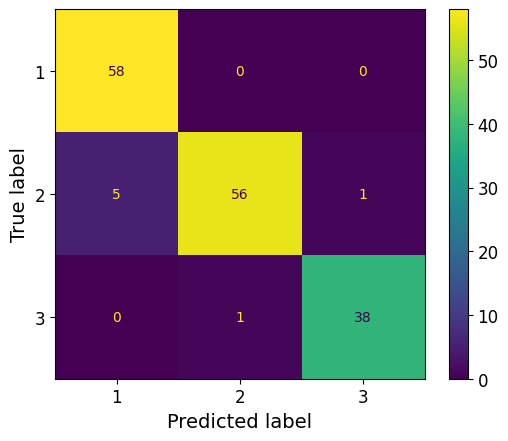

In [145]:
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(df_full.actual_labels, df_full.labels_JER)

In [146]:
print(classification_report(df_full.actual_labels, df_full.labels_JER))

              precision    recall  f1-score   support

           1       0.92      1.00      0.96        58
           2       0.98      0.90      0.94        62
           3       0.97      0.97      0.97        39

    accuracy                           0.96       159
   macro avg       0.96      0.96      0.96       159
weighted avg       0.96      0.96      0.96       159



*Por último, vamos a ver una matriz de confusión únicamente de los 6 últimos elementos, que son los valores nuevos a los que les asignamos unas etiquetas.* 

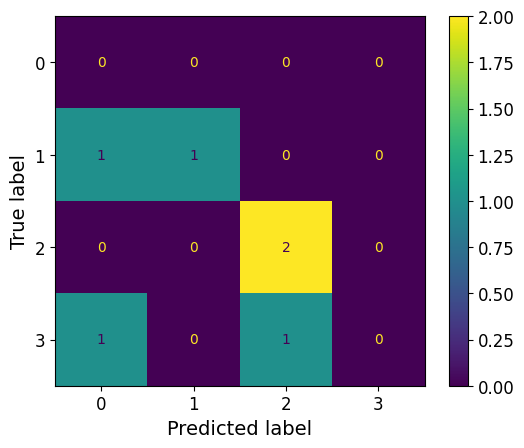

In [147]:
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(df_full[-6:].actual_labels, df_full[-6:].labels_DBSCAN)

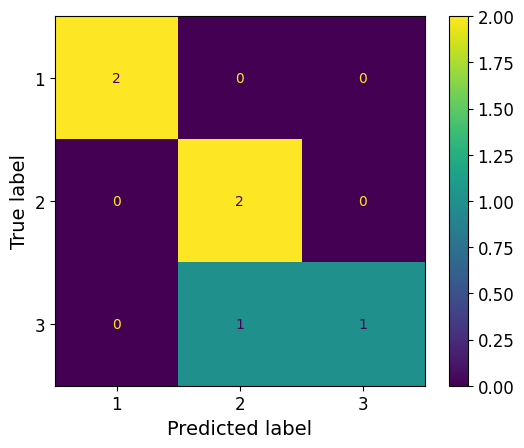

In [148]:
c_matrix = ConfusionMatrixDisplay(confusion_matrix= "cm")
c_matrix.from_predictions(df_full[-6:].actual_labels, df_full[-6:].labels_JER)

*Viendo los datos que nos ha pasado negocio con los que hemos podido evaluar nuestros modelos, parece que les interesaba más clasificar todos los productos en algún grupo, tarea que ha hecho bastante bien el cluster aglomerativo, ha cometido muy pocos errores, con tendencia a clasificar las bebidas como menos "energétcas" de los que son, pero en terminos generales es muy fiable (accuracy y recall medio del 96%). Podríamos haber forzado un poco más el dbscan para buscar algún valor de epsilon con menos outliers, pero en general para este problema va mejor el aglomerativo, aunque sí que hubiera sido útil la información que nos daba el DBSCAN si negocio nos hubiera dicho que le interesaban los valores que no encajaban demasiado bien en ningún grupo.*